In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [70]:
# data for the year
# weather info (clouds)
# trick to check null data graphically:
# fig, ax = plt.subplots(figsize=(20, 6))
# sns.heatmap(data.isnull(), cbar=False, yticklabels=False)

In [3]:
df = pd.read_csv('SolarPrediction.csv', dtype='str', keep_default_na=False, na_values=['', ' '])

In [4]:
df['Datetime'] = (df['Data'].apply(lambda x: x.split()[0].replace('/', '-')) + 'T' + df['Time']).apply(pd.to_datetime)
df = df.set_index('Datetime')
for var in ['Radiation', 'Pressure', 'WindDirection(Degrees)', 'Speed']:
    df[var] = df[var].astype(float)
for var in ['Temperature', 'Humidity']:
    df[var] = df[var].astype(int)

<AxesSubplot:title={'center':'Solar Radiation'}, xlabel='Datetime'>

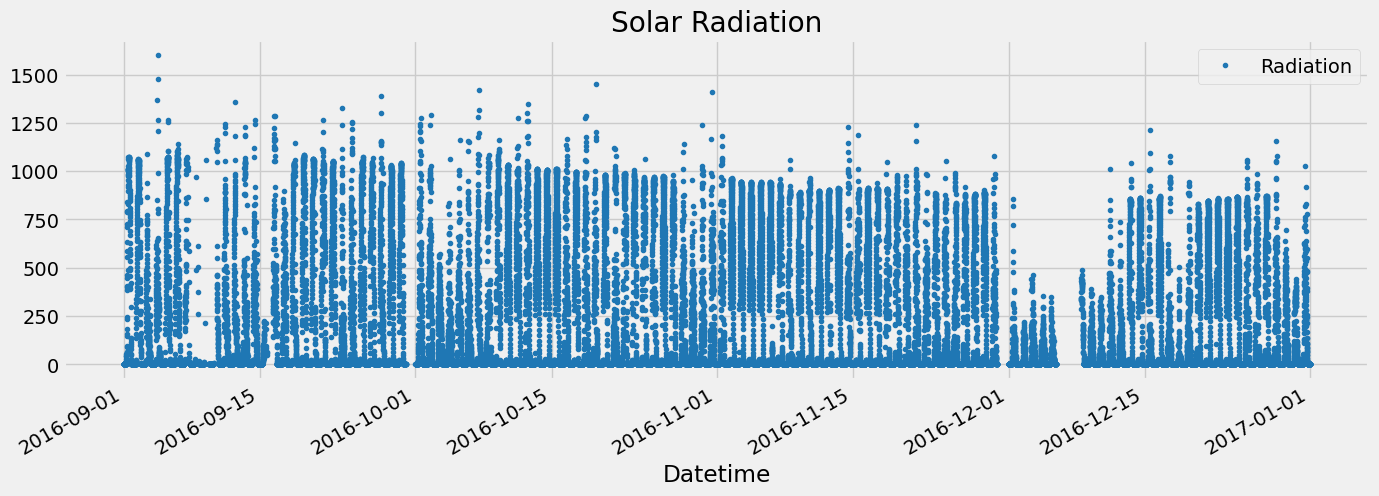

In [5]:
df[['Radiation']].plot(style='.', figsize=(15, 5), color=color_pal[0], title='Solar Radiation')

<AxesSubplot:title={'center':'Solar Radiation'}, xlabel='Datetime'>

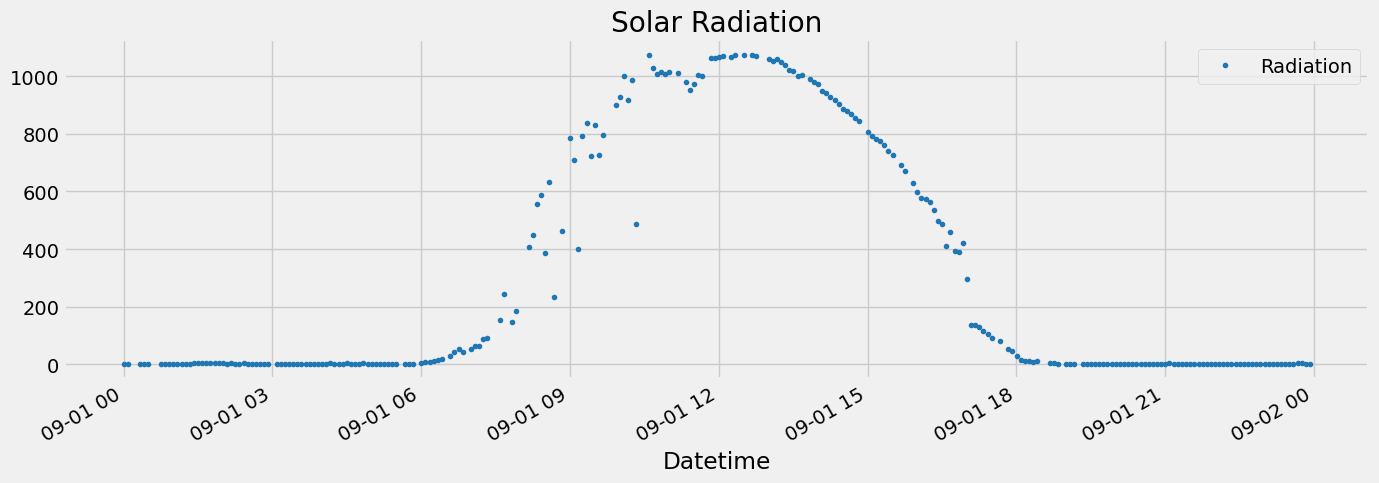

In [6]:
# day
df.loc[(df.index >= '09-01-2016') &
       (df.index < '09-02-2016')][['Radiation']].plot(style='.', figsize=(15, 5), color=color_pal[0],
                                                      title='Solar Radiation')

<AxesSubplot:title={'center':'Solar Radiation'}, xlabel='Datetime'>

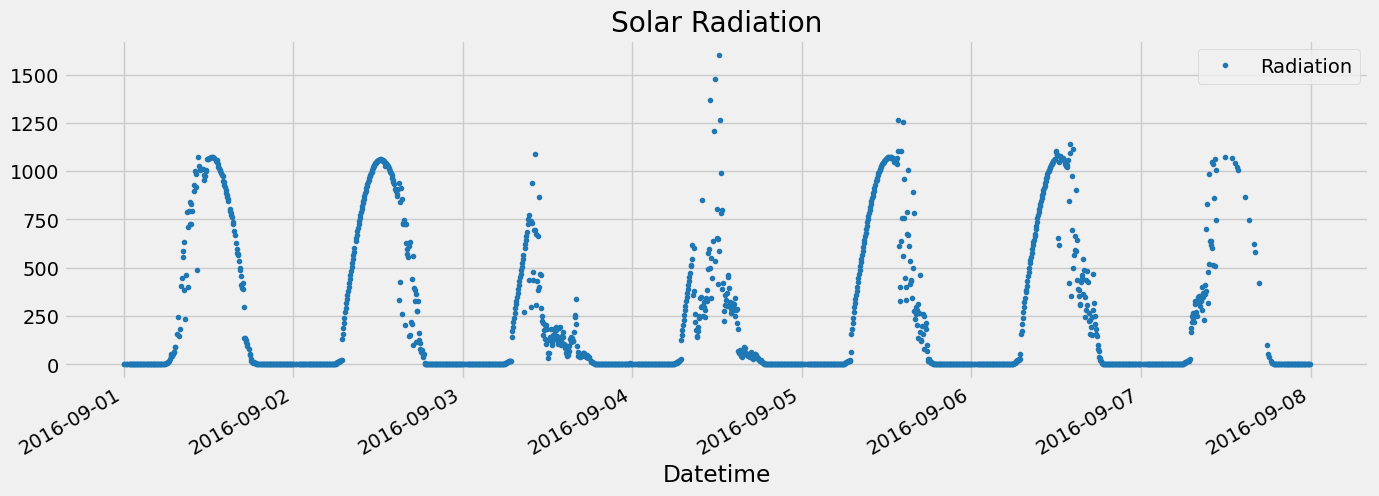

In [7]:
# week
df.loc[(df.index >= '09-01-2016') &
       (df.index < '09-08-2016')][['Radiation']].plot(style='.', figsize=(15, 5), color=color_pal[0],
                                                      title='Solar Radiation')

<AxesSubplot:title={'center':'Solar Radiation'}, xlabel='Datetime'>

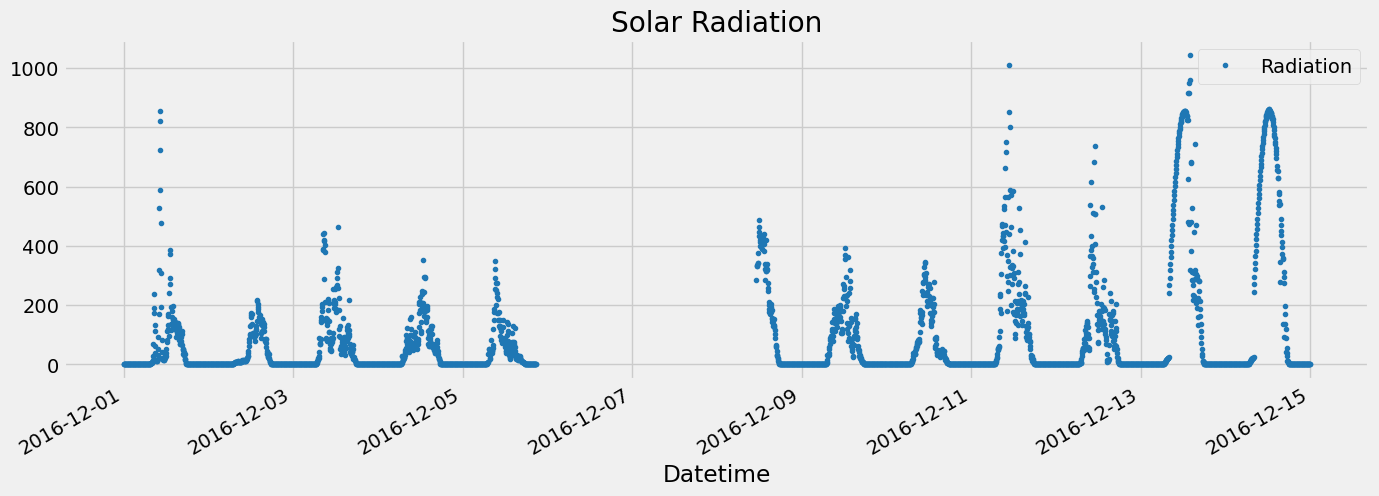

In [8]:
# abnorm december with na
df.loc[(df.index >= '12-01-2016') &
       (df.index < '12-15-2016')][['Radiation']].plot(style='.', figsize=(15, 5), color=color_pal[0],
                                                      title='Solar Radiation')

In [9]:
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['hour'] = df.index.hour
df['day'] = df.index.day

<AxesSubplot:xlabel='hour', ylabel='Radiation'>

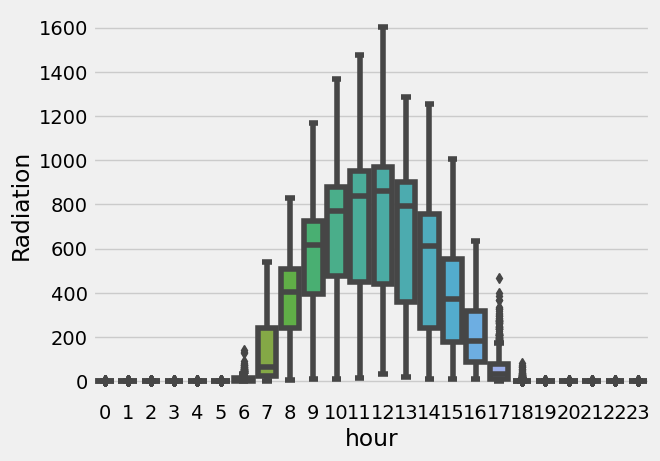

In [10]:
sns.boxplot(data=df, x='hour', y='Radiation')

In [36]:
FEATURES = ['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'quarter', 'month', 'hour']
TARGET = 'Radiation'

In [37]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [47]:
np.mean(scores)

157.91144572105327

In [51]:
train = df[df['day'] % 5 != 0]
test = df[df['day'] % 5 == 0]

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [52]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [53]:
rfr.feature_importances_

array([0.56268458, 0.02623645, 0.06035152, 0.04480507, 0.01407587,
       0.00311845, 0.01167638, 0.27705169])

In [55]:
test['prediction'] = rfr.predict(X_test)

In [56]:
np.sqrt(mean_squared_error(test['Radiation'], test['prediction']))

115.4566872589569

In [57]:
df_m = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

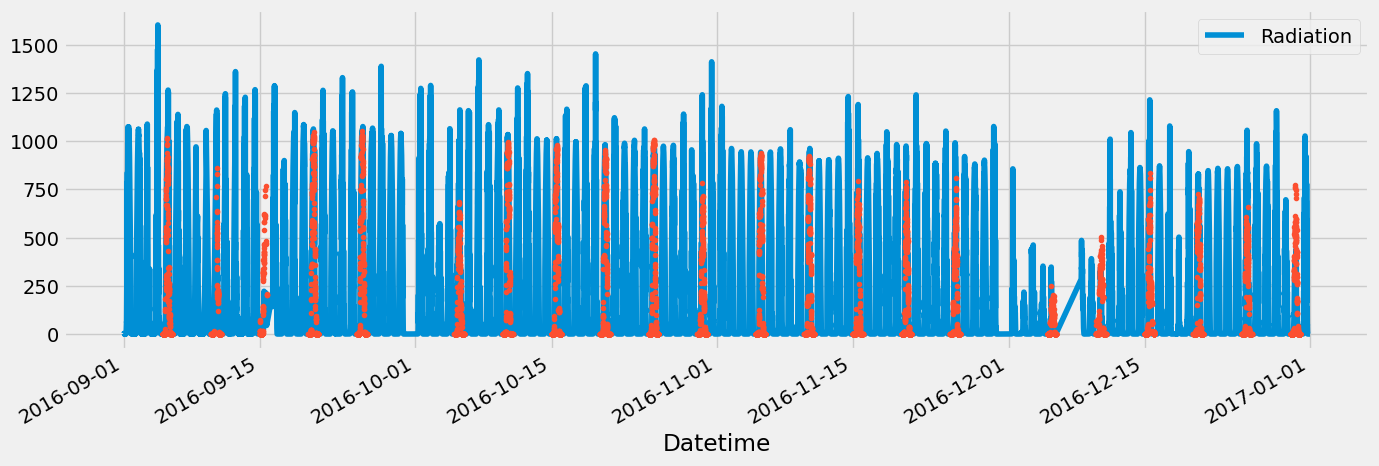

In [58]:
ax = df_m[['Radiation']].plot(figsize=(15, 5))
df_m['prediction'].plot(ax=ax, style='.')
plt.show()